In [135]:
import pandas as pd
import numpy as np
from itertools import combinations
from keras.models import Sequential, Model
from keras import layers
from keras import Input
import keras
import warnings
import seaborn as sns
import matplotlib.pyplot as plt 
import missingno as msno
import torch.nn as nn
import torch
from StockPredict import FeatureExtract

In [17]:
warnings.filterwarnings('ignore')
np.set_printoptions(precision=3, suppress=False)
pd.set_option('precision', 3)
pd.set_option('display.float_format',lambda x : '%.3f' % x)

In [132]:
def drop_nan_data(x, y, sample_size):
    init_x = x[:sample_size]
    init_y = y[:sample_size]
    
    for i in range(len(init_y)):
        if i == 0:
            sample_y = init_y[i]
            sample_x = init_x[i]
        else:
            sample_y = np.append(sample_y, init_y[i])
            sample_x = np.concatenate((sample_x, init_x[i]))
            
    for i in range(len(init_y)):
        condi = (~np.isnan(init_y[i])) & np.squeeze(~np.isnan(init_x[i]).any(axis=-1).any(axis=-1))
        if i == 0:
            dropna_y = init_y[i][condi]
            dropna_x = init_x[i][condi]
        else:
            dropna_y = np.append(dropna_y, init_y[i][condi])
            dropna_x = np.concatenate((dropna_x, init_x[i][condi]))
    
    return sample_x, sample_y, dropna_x, dropna_y

**Load data**

In [3]:
x = np.load('x_data.npy')
y = np.load('y_data.npy')

In [133]:
sample_x, sample_y, dropna_x, dropna_y = drop_nan_data(x, y, 100)

In [136]:
ftrExtract = FeatureExtract(9)
feature_extract = ftrExtract.feature_concat(dropna_x, 10)
feature_extract = np.squeeze(feature_extract)

In [139]:
print(f'Shape of x data: {x.shape}')
print(f'Shape of y data: {y.shape}')
print(f'Shape of sample x data: {sample_x.shape}')
print(f'Shape of sample y data: {sample_y.shape}')
print(f'Shape of dropna x data: {dropna_x.shape}')
print(f'Shape of dropna y data: {dropna_y.shape}')
print(f'Shape of feature extract data: {feature_extract.shape}')

Shape of x data: (2657, 300, 9, 30)
Shape of y data: (2657, 300)
Shape of sample x data: (30000, 9, 30)
Shape of sample y data: (30000,)
Shape of dropna x data: (12969, 9, 30)
Shape of dropna y data: (12969,)
Shape of feature extract data: (12969, 135, 21)


In [186]:
init_features = ['open','high','low','close','volume','pct_chg','vwap','turn','free_turn_n']
print('Transfer sample data and dropna data to 2d...')
sample_xy2d = pd.DataFrame(sample_x[:,:,0], columns=init_features)
sample_xy2d['up or down'] = sample_y

dropna_xy2d = pd.DataFrame(dropna_x[:, :, 0], columns=init_features)
dropna_xy2d['up or down'] = dropna_y

feature_extract2d = pd.DataFrame(feature_extract[:, :, 0], columns=['feature'+str(i) for i in range(1, 136, 1)])

Transfer sample data and dropna data to 2d...


**Data format**

In [140]:
print('Before feature extract...')
pd.DataFrame(x[0, 0], index=init_features, columns=['t'+str(i) for i in range(-30, 0, 1)])

Before feature extract...


,t-30,t-29,t-28,t-27,t-26,t-25,t-24,t-23,t-22,t-21,...,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1
open,0.000,17.320,18.060,17.990,18.650,18.200,19.400,19.120,19.150,19.470,...,19.100,18.970,19.160,18.540,18.200,18.210,17.250,17.300,16.570,16.930
high,17.340,18.360,18.150,18.550,19.290,19.380,20.060,19.630,19.980,19.500,...,19.190,19.390,19.180,18.550,18.660,18.290,17.320,17.300,17.070,17.270
low,16.500,17.320,17.800,17.970,18.310,18.180,19.100,18.830,19.150,18.770,...,18.790,18.970,18.600,18.100,18.080,17.130,16.990,16.660,16.510,16.850
close,17.220,18.040,17.970,18.540,18.340,19.150,19.170,19.550,19.470,18.850,...,18.930,19.140,18.650,18.130,18.440,17.190,17.310,16.700,16.800,17.180
volume,53671585.000,87403016.000,47759448.000,82596178.000,100374925.000,116893821.000,107408195.000,58071926.000,73972716.000,55499968.000,...,50395937.000,62519447.000,56692623.000,57120450.000,67968660.000,61625685.000,43991846.000,44266710.000,33927446.000,43733956.000
pct_chg,6.165,4.762,-0.388,3.172,-1.079,4.417,0.104,1.982,-0.409,-3.184,...,0.053,1.109,-2.560,-2.788,1.710,-6.779,0.698,-3.524,0.599,2.262
vwap,17.045,17.899,17.942,18.335,18.820,18.996,19.578,19.078,19.586,18.968,...,18.917,19.159,18.812,18.248,18.259,17.770,17.156,16.927,16.833,17.044
turn,1.728,2.815,1.538,2.660,3.232,3.764,3.459,1.870,2.382,1.787,...,1.623,2.013,1.826,1.839,2.189,1.984,1.417,1.425,1.093,1.408
free_turn_n,2.077,3.383,1.848,3.197,3.885,4.524,4.157,2.247,2.863,2.148,...,1.950,2.420,2.194,2.211,2.630,2.385,1.703,1.713,1.313,1.693


In [141]:
print('After feature extract...')
pd.DataFrame(feature_extract[0].T, index=['t'+str(i) for i in range(-21, 0, 1)], columns=['feature'+str(i) for i in range(1, 136, 1)]).head()

After feature extract...


,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature126,feature127,feature128,feature129,feature130,feature131,feature132,feature133,feature134,feature135
t-21,3.876,3.895,3.193,48637882.616,-10.803,3.616,1.566,1.882,0.714,0.613,...,3.033,16.736,19.024,18.193,18.630,78365177.800,1.554,18.625,2.524,3.033
t-20,0.399,0.397,0.281,-2259042.035,-1.263,0.353,-0.073,-0.087,0.364,0.331,...,3.033,18.591,19.171,18.376,18.760,78380239.800,0.763,18.777,2.524,3.033
t-19,0.277,0.235,0.166,-286609.252,-0.668,0.219,-0.009,-0.011,0.265,0.257,...,2.876,18.714,19.232,18.470,18.847,74322995.700,0.497,18.854,2.393,2.876
t-18,0.187,0.181,0.089,-3178984.853,-0.780,0.143,-0.102,-0.123,0.175,0.142,...,2.855,18.808,19.342,18.545,18.916,73770055.300,0.404,18.945,2.376,2.855
t-17,0.118,0.131,0.064,-1259481.073,-0.481,0.090,-0.041,-0.049,0.128,0.120,...,2.688,18.868,19.395,18.583,18.918,69460753.000,0.033,18.984,2.237,2.688


Initial data has many NAN values!


<AxesSubplot:>

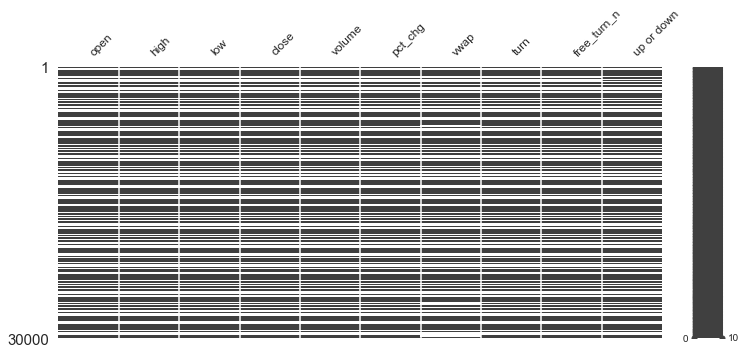

In [213]:
print('Initial data has many NAN values!')
msno.matrix(sample_xy2d, figsize=(12, 5), fontsize=12)

After dropna...


<AxesSubplot:>

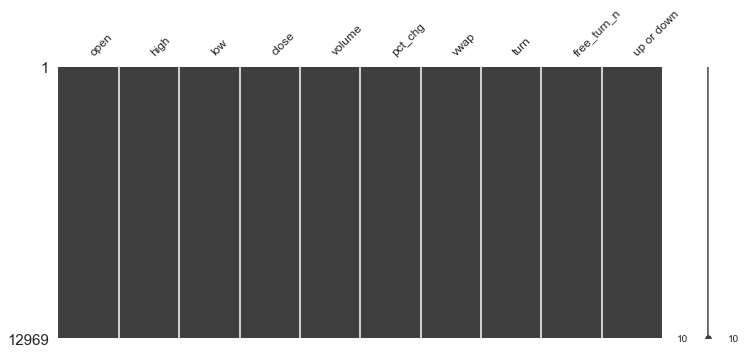

In [212]:
print('After dropna...')
msno.matrix(dropna_xy2d, figsize=(12, 5),fontsize=12)

## Features correlation <a class="anchor" id="distribution"></a>

<AxesSubplot:>

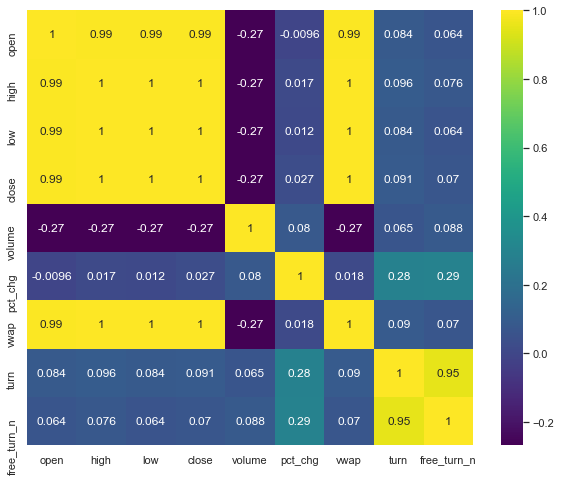

In [161]:
f, ax = plt.subplots(figsize=(10, 8))
sns.set(font_scale = 1)
sns.heatmap(dropna_xy2d[features].corr(), annot=True, ax=ax, cmap='viridis')

<AxesSubplot:>

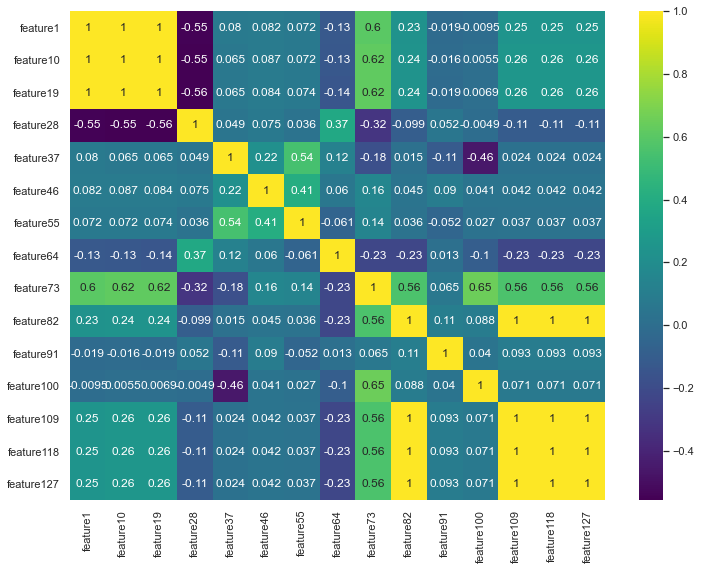

In [265]:
f, ax = plt.subplots(figsize=(12,9))
sns.set(font_scale = 1)
sns.heatmap(feature_extract2d.iloc[:5000, np.arange(0, 135, 9)].corr(), annot=True, ax=ax, cmap='viridis')

**Distribution of initial data without NAN**

Raw distributions: Features


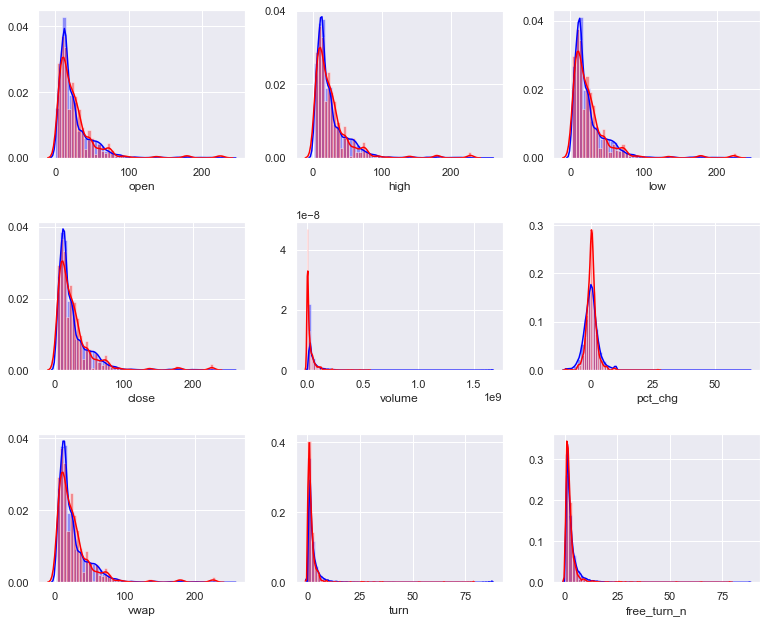

In [181]:
fig, ax = plt.subplots(3, 3, figsize=(11, 9))
sns.set(font_scale = 1.5)
print('Raw distributions: Features')
for i, ax in enumerate(fig.axes):
    if i < len(features):
        sns.distplot(dropna_xy2d[features[i]][:12000], color='blue', ax=ax)
        sns.distplot(dropna_xy2d[features[i]][12000:], color='red', ax=ax)
plt.tight_layout()

Raw distributions: Features


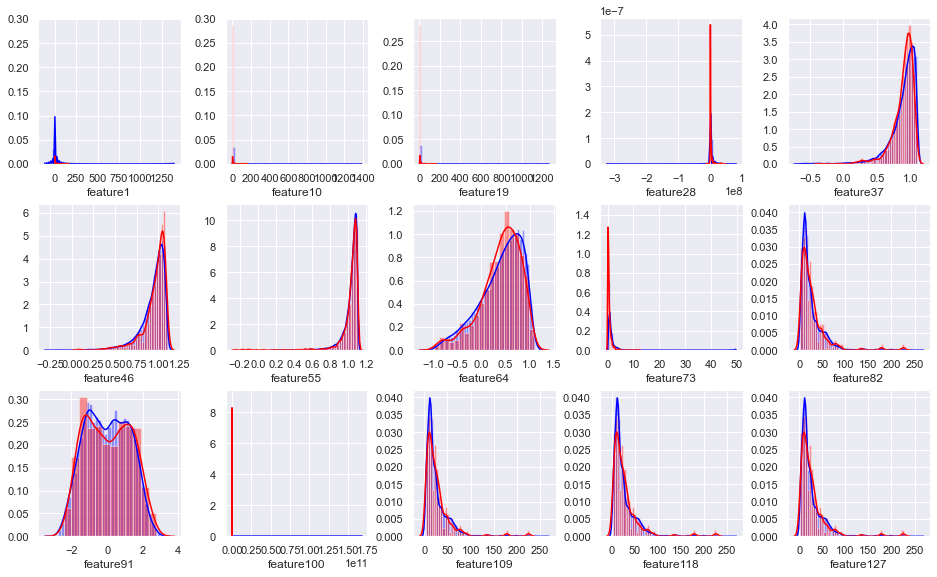

In [218]:
fig, ax = plt.subplots(3, 5, figsize=(13, 8))
data_plot = feature_extract2d.iloc[:, np.arange(0, 135, 9)]
sns.set(font_scale = 0.5)
print('Raw distributions: Features')
for i, ax in enumerate(fig.axes):
    sns.distplot(data_plot.iloc[:12000, i], color='blue', ax=ax)
    sns.distplot(data_plot.iloc[12000:, i], color='red', ax=ax)
plt.tight_layout()

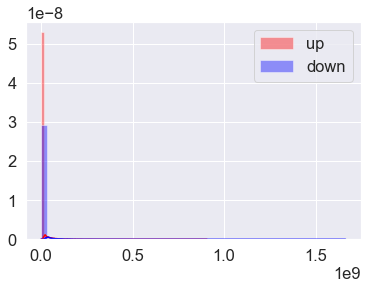

In [184]:
plt.figure()
sns.distplot(sample_xy2d[sample_xy2d['up or down']==1],color='red')
sns.distplot(sample_xy2d[sample_xy2d['up or down']==0],color='blue')
plt.legend(['up', 'down'])

In [242]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
norm_initial = sc.fit_transform(dropna_xy2d.iloc[:, :-1])
norm_feature_extract = sc.fit_transform(feature_extract2d)

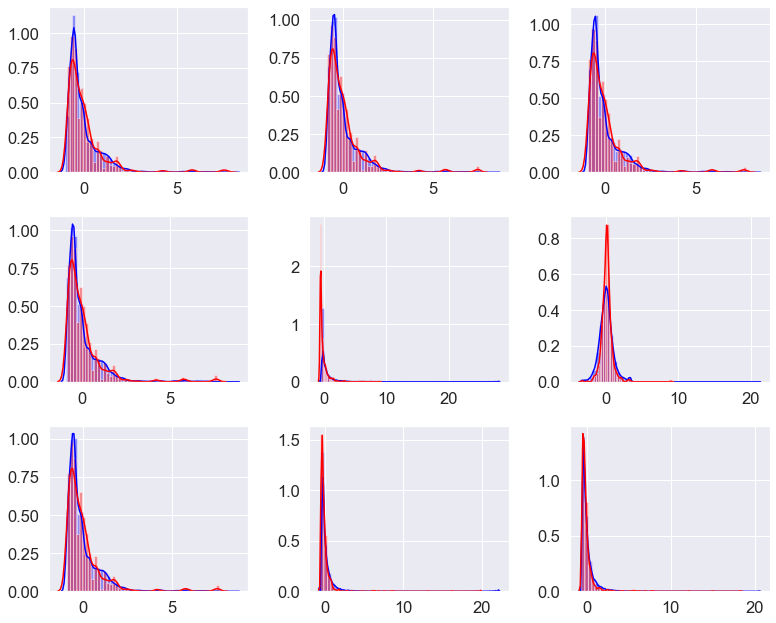

In [239]:
fig, ax = plt.subplots(3, 3, figsize=(11, 9))
# sns.set(font_scale = 1.5)
for i, ax in enumerate(fig.axes):
    if i < len(features):
        sns.distplot(norm_initial[:12000, i], color='blue', ax=ax)
        sns.distplot(norm_initial[12000:, i], color='red', ax=ax)
plt.tight_layout()

Raw distributions: Features


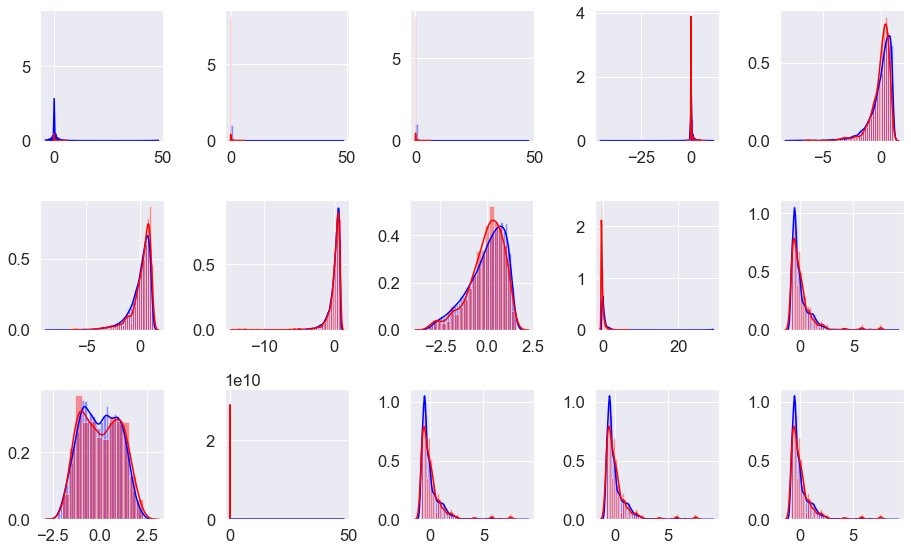

In [241]:
fig, ax = plt.subplots(3, 5, figsize=(13, 8))S
data_plot = norm_feature_extract[:, np.arange(0, 135, 9)]
# sns.set(font_scale = 0.5)
print('Raw distributions: Features')
for i, ax in enumerate(fig.axes):
    sns.distplot(data_plot[:12000, i], color='blue', ax=ax)
    sns.distplot(data_plot[12000:, i], color='red', ax=ax)
plt.tight_layout()